In [ ]:
import os
import shutil
from pathlib import Path

import cv2
from PIL import Image, ImageOps
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing.image import load_img, img_to_array
import mlflow
from mlflow.models.signature import infer_signature
import mlflow.sklearn

# Régle le nombre de threads
tf.config.threading.set_inter_op_parallelism_threads(4)  # Réglage entre opérations
tf.config.threading.set_intra_op_parallelism_threads(16)
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

model_name = "VGG16"

"""
Parameters
rgb: are images treated as rgb or grayscale
strategy: strategy to use for the transfered model: can be fine_tuning, feature_extraction or partial_fine_tuning
fixed-layers : only used with partial fine-tuning, wil define how many layers will stay untouched
epochs: how many epochs to go through
batch_size: how many img by batch size
img_size: self explanatory
"""
params = {
    "rgb": True,
    "strategy": "feature_extraction",
    "fixed-layers": 5,
    "epochs": 5,
    "batch_size": 200,
    "img_size": 200
}

train_folder = "data/2/chest_xray/train"
test_folder = "data/2/chest_xray/test"
train_output_folder = "data/processed/train"
test_output_folder = "data/processed/test"

In [ ]:
# Download latest version of dataset and store it locally
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

target_dir = "data"
os.makedirs(target_dir, exist_ok=True)
shutil.move(path, target_dir)

📸 Images aux valeurs extrêmes :
                                               filename width height  \
1240  data/2/chest_xray/train/NORMAL/NORMAL2-IM-1257...  2916   2583   
1025  data/2/chest_xray/train/NORMAL/NORMAL2-IM-0994...  2373   2663   
1583  data/2/chest_xray/train/PNEUMONIA/person1147_v...  1624   1944   
3357  data/2/chest_xray/train/PNEUMONIA/person325_vi...   446    132   
3677  data/2/chest_xray/train/PNEUMONIA/person407_vi...   384    127   

     aspect_ratio mode  error  
1240         1.13    L  False  
1025         0.89    L  False  
1583         0.84    L  False  
3357         3.38  RGB  False  
3677         3.02  RGB  False  


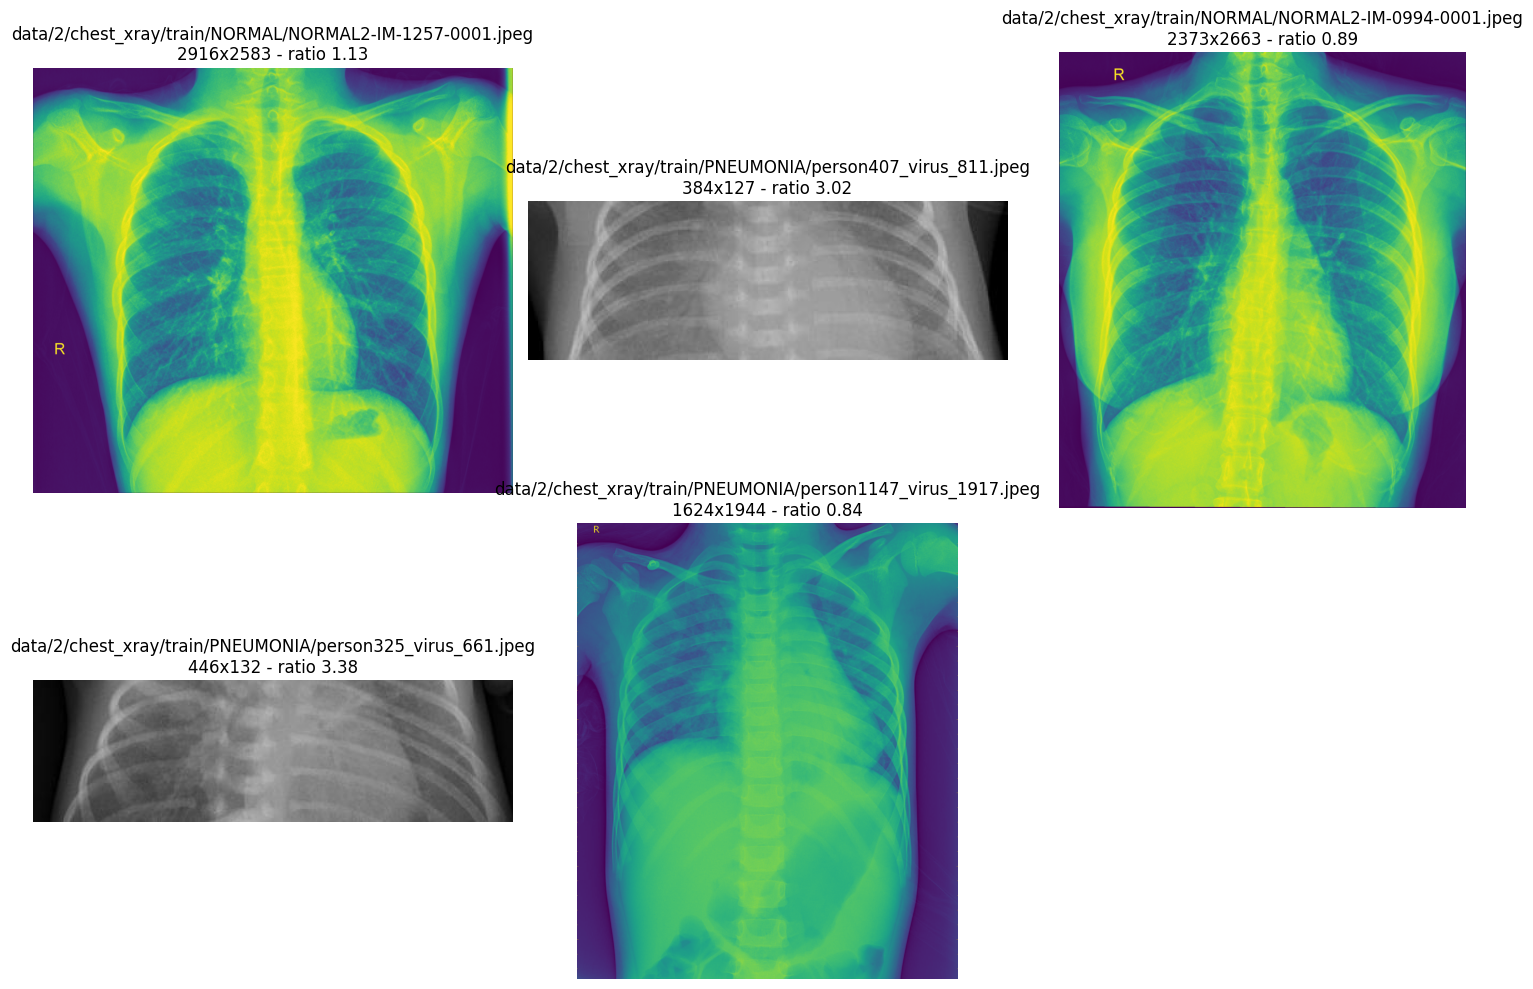

                                           filename  width  height  \
0  data/2/chest_xray/train/NORMAL/IM-0115-0001.jpeg   2090    1858   
1  data/2/chest_xray/train/NORMAL/IM-0117-0001.jpeg   1422    1152   
2  data/2/chest_xray/train/NORMAL/IM-0119-0001.jpeg   1810    1434   
3  data/2/chest_xray/train/NORMAL/IM-0122-0001.jpeg   1618    1279   
4  data/2/chest_xray/train/NORMAL/IM-0125-0001.jpeg   1600    1125   

   aspect_ratio mode  error  
0          1.12    L  False  
1          1.23    L  False  
2          1.26    L  False  
3          1.27    L  False  
4          1.42    L  False  
             width       height  aspect_ratio
count  5216.000000  5216.000000   5216.000000
mean   1320.610813   968.074770      1.440234
std     355.298743   378.855691      0.257314
min     384.000000   127.000000      0.840000
25%    1056.000000   688.000000      1.260000
50%    1284.000000   888.000000      1.410000
75%    1552.000000  1187.750000      1.580000
max    2916.000000  2663.000000

In [37]:
# Analyser les images
def get_image_info(file_path):
    try:
        with Image.open(file_path) as img:
            width, height = img.size
            return {
                "filename": file_path,
                "width": width,
                "height": height,
                "aspect_ratio": round(width / height, 2),
                "mode": img.mode,
                "error": False
            }
    except Exception as e:
        return {
            "error": str(e)
        }
    
def get_images_info(folder_path):
    
    images_info = []

    for label in sorted(os.listdir(folder_path)):

        if not label in ("NORMAL", "PNEUMONIA"):
            continue
        label_path = os.path.join(folder_path, label)

        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)

            info = get_image_info(file_path)
            images_info.append(info)

    df = pd.DataFrame(images_info)
    return df

def show_images(df_extremes, folder_path, ncols=3):
    folder = Path(folder_path)
    n = len(df_extremes)
    nrows = (n + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
    axes = axes.flatten()

    for idx, row in df_extremes.iterrows():
        img_path = Path(row["filename"])
        with Image.open(img_path) as img:
            axes[idx].imshow(img)
            axes[idx].set_title(f'{row["filename"]}\n{row["width"]}x{row["height"]} - ratio {row["aspect_ratio"]}')
            axes[idx].axis('off')

    # Cacher les cases vides si besoin
    for i in range(len(df_extremes), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()    

df_train_images = get_images_info(train_folder)
df_train_valid = df_train_images[df_train_images["error"] == False]

# Identifier les images extrêmes
extremes = pd.concat([
    df_train_valid.loc[df_train_valid["width"].idxmax()],
    df_train_valid.loc[df_train_valid["width"].idxmin()],
    df_train_valid.loc[df_train_valid["height"].idxmax()],
    df_train_valid.loc[df_train_valid["height"].idxmin()],
    df_train_valid.loc[df_train_valid["aspect_ratio"].idxmax()],
    df_train_valid.loc[df_train_valid["aspect_ratio"].idxmin()],
], axis=1).T.drop_duplicates()

# Affichage en tableau
print("📸 Images aux valeurs extrêmes :")
print(extremes.sort_values(by=["width", "height"], ascending=[False, False]))

# Affichage des images extrêmes
show_images(extremes.reset_index(drop=True), folder_path=train_folder)

# Aperçu
print(df_train_images.head())
# Statistiques
print(df_train_images.describe())


In [38]:
def square_image(image:Image):
    width, height = image.size
    size = max(width, height)

    border_w = size - width
    border_h = size - height

    padding = (
        border_w // 2,
        border_h // 2,
        border_w - (border_w // 2),
        border_h - (border_h // 2),
    )

    squared_img = ImageOps.expand(image, padding, fill="black")
    
    return squared_img

def prepare_data(input_folder:str, output_folder:str):
    """    
    passer toutes les images en nuances de gris
    Ajouter des bandes noires pour rendre toutes les images carrées
    redimensionner toutes les images
    """
    input_folder = Path(input_folder)
    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)
    
    for file_path in input_folder.rglob("*"):
        if file_path.is_file():
            try:
                with Image.open(file_path) as img:
                    # Convert image to color profile
                    if params["rgb"]:
                        img = img.convert("RGB")
                    else:
                        img = img.convert("L")
                        
                    # Add black borders to square image
                    img = square_image(img)
                    # Resize image
                    img = img.resize((params["img_size"], params["img_size"]), resample=Image.BILINEAR)

                    # Save image
                    rel_path = file_path.relative_to(input_folder)
                    output_path = output_folder / rel_path
                    output_path.parent.mkdir(parents=True, exist_ok=True)
                    output_path = output_path.with_suffix(".jpeg")

                    img.save(output_path)

            except Exception as e:
                print(f"❌ Error processing {file_path.name}: {e}")

prepare_data(train_folder, train_output_folder)
prepare_data(test_folder, test_output_folder)

In [13]:
# Préparation des données
def get_train_test(base_path: str):
    X = []  # liste pour stocker les images
    y = []  # liste pour stocker les étiquettes correspondantes

    # On parcourt les sous-dossiers du répertoire (un dossier par chiffre)
    for label in sorted(os.listdir(base_path)):
        # on ignore les fichiers qui ne sont pas des dossiers de chiffres
        if not label in ("NORMAL", "PNEUMONIA"):
            continue
        label_path = os.path.join(base_path, label)

        # On parcourt chaque image du dossier
        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)
            if params["rgb"]:                
                img = cv2.imread(file_path, cv2.IMREAD_COLOR_RGB)
            else:
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

            if img is None:
                print("Corrupted image")
                continue
            
            X.append(img)           # on ajoute l'image à la liste
            y.append(1 if label == "PNEUMONIA" else 0)

    # Conversion des listes en tableaux NumPy
    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = get_train_test("data/processed/train")
X_test, y_test = get_train_test("data/processed/test")


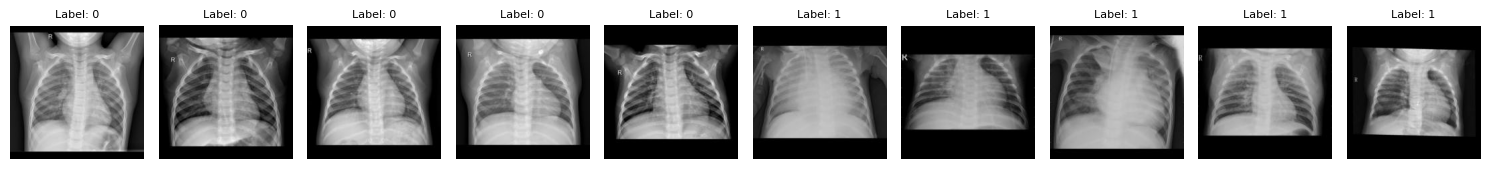

In [40]:
# Sélectionner les indices des labels
indices_label_0 = [i for i, y in enumerate(y_train) if y == 0][:5]
indices_label_1 = [i for i, y in enumerate(y_train) if y == 1][:5]

# Fusionner les indices sélectionnés
selected_indices = indices_label_0 + indices_label_1

# Affichage
plt.figure(figsize=(15, 3))
for idx, i in enumerate(selected_indices):
    plt.subplot(1, 10, idx + 1)
    plt.imshow(X_train[i], cmap="gray")
    plt.title(f"Label: {y_train[i]}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [14]:
# Preprocessing
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

# Normalisation : on divise les valeurs de pixels par 255 pour les ramener entre 0 et 1
X_train /= 255.0
X_test /= 255.0

#Transform y_train, y_test to the shape expected by the model
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# On n'aplatit pas maintenant car les convolution ont besoin de matrices

In [17]:
"""
Création du modèle
le transfer learning evite l'overfitting
choix du mopdèle préentrainé:
-VGG-16
entrée couleur 224*224


Bloc 1 : Convolution pour repérer les features
couche relu come fonction d'activation
pooling entre deux groupes de couches de covnolution (soit 2x2 sans chevauchement soit 3x3 avec chevauxhement)
Répéter ? selon resultats
ameliore l'efficacité et evite le suraprentissage

parametres convolution:
nb de filtres K
taile des filtres F
pas S
zero-padding P

Pour la couche de convolution, les filtres sont de petite taille et glissés sur l'image d'un pixel à la fois. La valeur du zero-padding est choisie de sorte que la largeur et la hauteur du volume en entrée ne soient pas modifiées en sortie. En général, on choisit alors F=3,P=1,S=1
 ou F=5,P=2,S=1

P = (F-1)/2
S = 1

parametres pooling:
taille des cellules F
pas S

Pour la couche de pooling, F=2
 et S=2
 est un choix judicieux. Cela permet d'éliminer 75% des pixels en entrée. On peut également trouver F=3
 et S=2
 : dans ce cas, les cellules se chevauchent. Choisir des cellules de plus grande taille provoque une perte trop importante d'informations, et donne de moins bons résultats en pratique

Flatten
Bloc final : Dense - fonction logistique pour classification binaire
"""

model = VGG16(weights="imagenet", include_top=False, input_shape=(200, 200, 3))

x = model.output
x = layers.GlobalAveragePooling2D()(x)

predictions = layers.Dense(2, activation="softmax")(x)

custom_model = models.Model(inputs=model.input, outputs=predictions)

# Adjust to chosen strategy
if params["strategy"] == "fine_tuning":
   for layer in model.layers:
      layer.trainable = True
elif params["strategy"] == "partial_fine_tuning":
   for layer in model.layers[:params["fixed-layers"]]:
      layer.trainable = False
else:
   for layer in model.layers:
      layer.trainable = False

# Compiler le modèle 
custom_model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(learning_rate=0.0001, momentum=0.9), metrics=["recall", "accuracy", "precision", "auc", "mean_squared_error"])

custom_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,715,714 (56.14 MB)

 Trainable params: 1,026 (4.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [18]:
# Entrainement du modèle
model_info = custom_model.fit(
    X_train, y_train,
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    validation_data=(X_test, y_test),
    verbose=2)

Epoch 1/5
27/27 - 422s - 16s/step - accuracy: 0.7429 - auc: 0.7726 - loss: 0.5698 - mean_squared_error: 0.1909 - precision: 0.7429 - recall: 0.7429 - val_accuracy: 0.6250 - val_auc: 0.5991 - val_loss: 0.6963 - val_mean_squared_error: 0.2487 - val_precision: 0.6250 - val_recall: 0.6250
Epoch 2/5
27/27 - 432s - 16s/step - accuracy: 0.7429 - auc: 0.7911 - loss: 0.5635 - mean_squared_error: 0.1885 - precision: 0.7429 - recall: 0.7429 - val_accuracy: 0.6250 - val_auc: 0.6115 - val_loss: 0.7063 - val_mean_squared_error: 0.2524 - val_precision: 0.6250 - val_recall: 0.6250
Epoch 3/5
27/27 - 422s - 16s/step - accuracy: 0.7429 - auc: 0.8085 - loss: 0.5611 - mean_squared_error: 0.1876 - precision: 0.7429 - recall: 0.7429 - val_accuracy: 0.6250 - val_auc: 0.6277 - val_loss: 0.7028 - val_mean_squared_error: 0.2511 - val_precision: 0.6250 - val_recall: 0.6250
Epoch 4/5
27/27 - 410s - 15s/step - accuracy: 0.7429 - auc: 0.8211 - loss: 0.5586 - mean_squared_error: 0.1867 - precision: 0.7429 - recall: 0

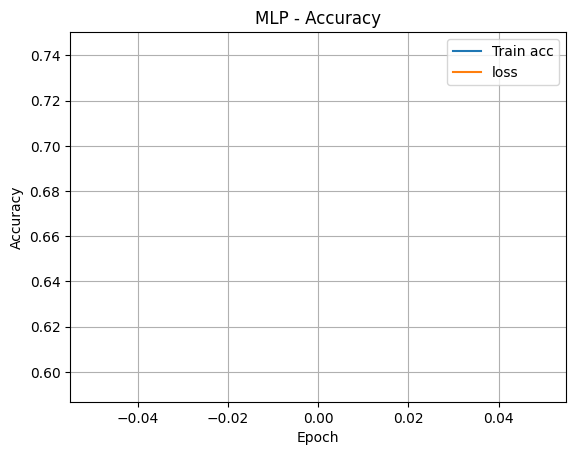

{'loss': [0.5942003130912781],
 'recall': [0.7429064512252808],
 'val_loss': [0.7123966217041016],
 'val_recall': [0.625]}

In [ ]:
"""
for i, recall in enumerate(model_info.history["recall"]):
    precision = model_info.history["precision"][i]
    f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    model_info.history["f1-score"].append(f1_score)
"""

# Evaluation du modèle
plt.plot(model_info.history["recall"], label='Train acc')
plt.plot(model_info.history["recall_val"], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("MLP - Accuracy")
plt.legend()
plt.grid(True)
plt.show()

model_info.history

In [ ]:
# Log into MLFlow
mlflow.set_experiment("Initial testing")
mlflow.set_tracking_uri("http://localhost:5000/")

with mlflow.start_run(model_name):
    mlflow.log_params(params)
    mlflow.log_metrics({
        model_info.history
    })
    mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path=model_name,
            input_example=X_test[:5],
            signature = infer_signature(X_test, model.predict(X_test))
        )

2025/05/22 20:52:34 INFO mlflow.tracking.fluent: Experiment with name 'First Experiment' does not exist. Creating a new experiment.


'\nwith mlflow.start_run():\n    mlflow.log_params(parameters)\n    mlflow.log_metrics({\n        "accuracy": acc,\n        "loss": loss\n    })\n    mlflow.sklearn.log_model(\n            sk_model=model,\n            artifact_path="Cats and Dogs model",\n            input_example=X_test[:5],\n            signature = infer_signature(X_test, model.predict(X_test))\n        )\n'

In [ ]:
# Register a model
model_name = input("Enter model name")
run_id = input("Enter run ID")
model_uri = f"runs:/{run_id}/model"

result = mlflow.register_model(model_uri, model_name)

Successfully registered model 'test'.
2025/05/22 20:52:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: test, version 1
Created version '1' of model 'test'.


In [ ]:
# Load a model
model_name = input("Enter model name")
model_version = int(input("Enter model version"))
alias = "challenger"

model_uri = f"models:/{model_name}/{model_version}"
#model_uri = f"models:/{model_name}@{alias}"

loaded_model = mlflow.sklearn.load_model(model_uri)
y_pred = loaded_model.predict(X_test)
y_pred[:4]